In [1]:
'''
Change these paths according to your folder structure.
'''
train_data_path ="./trainset"
test_data_path ="./testset"

# Where to save the checkpoints during training
checkpoint_path ="./checkpoints"

In [2]:
%pylab inline
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
import numpy as np
from PIL import Image
import os
import glob


class CatDogDataset(Dataset):
    splits = ('train', 'train+unlabeled', 'unlabeled', 'test')

    def __init__(self, root, split='train', transform=None, target_transform=None):
        if split not in self.splits:
            raise ValueError('Split "{}" not found. Valid splits are: {}'.format(
                split, ', '.join(self.splits),
            ))
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.split = split  # train/test
        self.classes = np.asarray(['Dog', 'Cat'])
        self.labels = None
        if self.split == 'train':
            self.paths = glob.glob(os.path.join(root, 'Dog', "*.jpg"))
            assert self.paths, "Dog folder contains no jpg, probably wrong path"
            
            cats = glob.glob(os.path.join(self.root, 'Cat', "*.jpg"))
            assert cats, "Cat folder contains no jpg, probably wrong path"
            self.paths.extend(cats)
            self.labels = [(0 if self.paths[i][-7:-4]=='Dog' else 1) for i,path in enumerate(self.paths)]
        elif self.split == 'test':
            self.paths = glob.glob(os.path.join(root, "*.jpg"))
            assert self.paths, "Test folder contains no jpg, probably wrong path"            
            self.paths = [os.path.join(root, "{}.jpg".format(i)) for i in range(1, len(self.paths) + 1)]

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img = Image.open(self.paths[index]).convert('RGB')
        
        if self.labels is not None:
            target = int(self.labels[index])
        else:
            target = torch.Tensor(0)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.paths)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Loading dataset

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
batch_size = 32
validationRatio = 0.1

dataset = CatDogDataset(train_data_path, split='train', transform=transforms.ToTensor(), target_transform=None)

indices = torch.randperm(len(dataset))
train_indices = indices[:len(indices) - int((validationRatio) * len(dataset))]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_indices = indices[len(indices) - int(validationRatio * len(dataset)):]
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)

# Dataset
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=batch_size,
                                           sampler = train_sampler,
                                           shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=batch_size,
                                           sampler = valid_sampler,
                                           shuffle=False)

In [4]:
import torch

def save_checkpoint(acc, best_acc, checkpoints_path):
  state_dict = {
          'epoch': epoch + 1,
          'model_dict': model.state_dict(),
          'optim_dict': optimizer.state_dict()
        }
  torch.save(state_dict,
         os.path.join(checkpoints_path,
                      "last.pth".format(acc)))
  if acc > best_acc:
    if best_acc > 0:
      os.remove(
          os.path.join(
              checkpoints_path,
              "best_{acc:.4f}.pth".format(acc=best_acc)
          )
      )
    best_acc = acc
    torch.save(state_dict,
               os.path.join(checkpoints_path,
                            "best_{acc:.4f}.pth".format(acc=acc)))
  return best_acc

def load_checkpoint(model, checkpoint_path, optimizer=None, continue_from_epoch=True):
    print("Loading checkpoint: {}".format(checkpoint_path))
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['model_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(state['optim_dict'])

    epoch = 0
    if continue_from_epoch:
        epoch = state['epoch']
    return epoch

In [5]:
from torch.optim import Optimizer
from torch.optim.optimizer import required

class SGDNesterov(Optimizer):
  def __init__(self, params, lr=required, momentum=0.9):
    defaults = dict(lr=lr, momentum=momentum)
    super(SGDNesterov, self).__init__(params, defaults)

  def __setstate__(self, state):
    super(SGDNesterov, self).__setstate__(state)
    for group in self.param_groups:
        group.setdefault('nesterov', True)

  def step(self):
    loss = None

    for group in self.param_groups:
        momentum = group['momentum']

        for p in group['params']:
            if p.grad is None:
                continue
            d_p = p.grad.data
            if momentum != 0:
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                  buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                else:
                  buf = param_state['momentum_buffer']
                  
                buf.mul_(momentum).add_(d_p)
                d_p = d_p.add(momentum, buf)

            p.data.add_(-group['lr'], d_p)

    return loss

In [6]:
from torch.nn import Module
from torch.nn import Parameter
from torch.nn import init

class BatchNorm(Module):
  def __init__(self, num_features):
      super(BatchNorm, self).__init__()
      self.num_features = num_features
      self.gamma = Parameter(torch.Tensor(num_features))
      self.beta = Parameter(torch.Tensor(num_features))
      self.reset()
  
  def reset(self):
    init.uniform_(self.gamma)
    init.zeros_(self.beta)

  def forward(self, input):
    mu = input.mean((0,2,3), keepdim=True)
    variance = torch.mean((input - mu) ** 2, (0,2,3), keepdim=True)
    input_norm = (input - mu) / torch.sqrt(variance + 1e-5)
    out = self.gamma.view(1, self.num_features, 1, 1) * input_norm + self.beta.view(1, self.num_features, 1, 1)
    return out

  def extra_repr(self):
      return 'num_features={}'.format(
          self.num_features
      )

In [7]:
from torch.nn import Module
from torch.nn import Parameter
from torch.nn import init
from torch.autograd import Variable

class Dropout(Module):
  def __init__(self, p=0.5):
      super(Dropout, self).__init__()
      self.p = p

  def forward(self, input):
    if self.train():
      prob = torch.ones(input.size()) * self.p
      dropout = Variable(torch.bernoulli(prob)).to("cuda:0")
      output = input * dropout * (1/(1-self.p))
    else:
      output = input
    
    return output

  def extra_repr(self):
      return 'p={}'.format(
          self.p
      )

In [8]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.optim import lr_scheduler

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, cfg, num_classes=2):
        super(ConvNet, self).__init__()
        self.cfg = cfg
        self.features = self.make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.ReLU(True),
            Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            Dropout(),
            nn.Linear(1024, num_classes),
        )
        
    def make_layers(self):
      print(self.cfg)
      layers = []
      in_channels = 3
      for v in self.cfg:
          if v == 'M':
              layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
          else:
              conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
              layers += [conv2d, BatchNorm(v), nn.ReLU(inplace=True)]
              in_channels = v
      return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
num_classes = 2
model = ConvNet([64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M'], num_classes).to(device)

[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M']


In [10]:
checkpoint_for_prediction = checkpoint_path+"/best_89.3947.pth"
print(checkpoint_for_prediction)

C:/Users/mikap/OneDrive/Documents/GitHub/IFT6135/Q3/checkpoints/best_89.3947.pth


In [11]:
'''
This cell is for producing a prediction csv file on the test dataset.
Run all the cells before this one first.
'''
import torch.nn.functional as F
import pandas as pd

def testModel(test_dir, local_model):
    local_model.eval()
    print ('Testing model: {}'.format(str(local_model)))

    test_set = CatDogDataset(test_dir, split='test', transform=transforms.ToTensor(), target_transform=None)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=batch_size,
                                           shuffle=False)
    print(test_loader)

    predictions = []
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        # compute y_pred
        y_pred = model(images).data.max(1)[1].cpu().numpy()
        predictions.extend(test_set.classes[y_pred])

    return predictions

def predictions_to_csv(predictions, csv_path):
    fd = pd.DataFrame({"label": predictions})
    fd.index = np.arange(1, len(predictions) + 1)
    fd.to_csv(csv_path, index_label="id")

# Making prediction and saving

load_checkpoint(model, checkpoint_for_prediction)
predictions = testModel(test_data_path, model)
csv_path='./submission.csv'
predictions_to_csv(predictions, csv_path)

Loading checkpoint: C:/Users/mikap/OneDrive/Documents/GitHub/IFT6135/Q3/checkpoints/best_89.3947.pth
Testing model: ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(num_features=64)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm(num_features=128)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm(num_features=256)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm(num_features=256)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), st

In [12]:
'''
This cell is for training the model and saving checkpoints
'''
from datetime import datetime
import os

# Hyper parameters
num_epochs = 50
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = SGDNesterov(model.parameters(), lr=learning_rate, momentum=0.9)

# Train the model
trainLoss = []
validLoss = []
validAcc = []

total_step = len(train_loader)
trainAcc = []
best_acc = 0
datetime_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
checkpoints_saving_path = os.path.join(checkpoint_path, datetime_str)
os.makedirs(checkpoints_saving_path, exist_ok=True)
for epoch in range(num_epochs):
    print('Epoch [{}/{}]'.format(epoch+1, num_epochs))
    meanLoss = 0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_this_batch = (predicted == labels).sum().item()
        correct += correct_this_batch
        loss = criterion(outputs, labels)
        meanLoss += loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Step [{}/{}], Loss: {:.4f}({:.4f}), Acc: {:.3f}({:.3f})' 
                   .format(i+1, total_step, loss.item(), meanLoss / (i+1), correct_this_batch * 100 / labels.size(0), correct * 100 / total, )) 
        trainLoss.append(meanLoss/(i+1))
        trainAcc.append(100*correct / total)
    
    
    # valid the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        meanLoss = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            meanLoss += loss.cpu().detach().numpy()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        acc  = 100 * correct / total
        print('Validation Accuracy : {:.4f} %, Loss : {:.4f}'.format(100 * correct / total, meanLoss/len(valid_loader)))
        validLoss.append(meanLoss/len(valid_loader))
        validAcc.append(acc)
        best_acc = save_checkpoint(acc, best_acc, checkpoints_saving_path)

Epoch [1/50]


KeyboardInterrupt: 

In [13]:
import numpy as np
submit1 = np.loadtxt("./submission.csv", skiprows=1, dtype=str, delimiter=',')
submit1 = submit1[:, 1]
submit2 = np.loadtxt("./submission1.csv", skiprows=1, dtype=str, delimiter=',')
submit2 = submit2[:, 1]

print(np.sum(submit1 == submit2) / len(submit1))

OSError: ./submission1.csv not found.

In [14]:
#Cell used for visual analysis

import torch.nn.functional as F
load_checkpoint(model, checkpoint_for_prediction,optimizer)
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
misclass_max=np.zeros((5, 1))
close_min=np.zeros((5, 1))
close_min[:]=100
images_close=torch.randn((5,3, 64, 64))
images_misclass=torch.randn((5,3,64,64))
proba_misclass=[]
proba_class=[]
prop_cat=[]
flag=1
with torch.no_grad():
    correct = 0
    total = 0
    meanLoss = 0
    for count, (images, labels) in enumerate(valid_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
                       
                       
        loss = criterion(outputs, labels)
        meanLoss += loss.cpu().detach().numpy()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        outputs_show=F.softmax(outputs)
        outputs_show=outputs_show.cpu()
        outputs_show=outputs_show.numpy()
        diff=abs(outputs_show[:,0]-outputs_show[:,1])
        proba=np.amax(outputs_show,axis=1)
        #Retrieve the clearly misclassified images and the uncertain classification
        for j in range(len(outputs_show)):
          if diff[j]<max(close_min):
            
            close_min[argmax(close_min)]=diff[j]
            images_close[argmax(close_min)]=images[j]
          
          if predicted[j]!=labels[j]:
            prop_cat.append(labels[j].cpu().numpy())
            proba_misclass.append(proba[j])
            
            if diff[j]>min(misclass_max):
              misclass_max[argmin(misclass_max)]=diff[j]
              images_misclass[argmin(misclass_max)]=images[j]
          else: 
            proba_class.append(proba[j])
            if (proba[j]>0.999999999 and flag):
              flag=0
              im_fm_good_tens=images[j].unsqueeze(0)
              im_fm_good=images[j].detach().cpu().numpy()
              im_fm_good_id=j
              im_fm_good_batch=count
              
            
            


    acc  = 100 * correct / total
    print('Validation Accuracy : {:.4f} %, Loss : {:.4f}'.format(100 * correct / total, meanLoss/len(valid_loader)))
    proba_class=np.asarray(proba_class)
    proba_misclass=np.asarray(proba_misclass)
    proba_c=mean(proba_class)
    proba_m=mean(proba_misclass)
    print("Dominant class mean probability for a good classification : {:.4f}, and for a misclassification : {:.4f} ".format(proba_c,proba_m))
    prop_c=mean(prop_cat)
    print("Proportion of misclassified images that is cat labeled: {:.2f}".format(prop_c))
    print(close_min)
    print(misclass_max)

Loading checkpoint: C:/Users/mikap/OneDrive/Documents/GitHub/IFT6135/Q3/checkpoints/best_89.3947.pth


C:\Users\mikap\Desktop\WPy-3670\python-3.6.7.amd64\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation Accuracy : 98.9495 %, Loss : 0.0439
Dominant class mean probability for a good classification : 0.9964, and for a misclassification : 0.8305 
Proportion of misclassified images that is cat labeled: 0.62
[[0.16331762]
 [0.22503728]
 [0.04856387]
 [0.02640072]
 [0.0721325 ]]
[[0.99293798]
 [0.99999714]
 [0.99999243]
 [0.99568754]
 [0.99997687]]


C:\Users\mikap\Desktop\WPy-3670\python-3.6.7.amd64\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


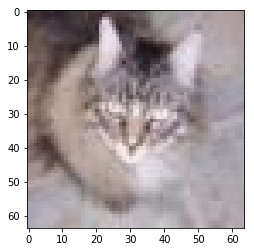

1
0


In [15]:
#Print the image correcly classified
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
img = np.zeros((64,64,3))
img[:,:,0] = im_fm_good[0]
img[:,:,1] = im_fm_good[1]
img[:,:,2] = im_fm_good[2]
name = 'image_fm_good.jpg'
scipy.misc.toimage(img).save(name)
plt.imshow(img)
plt.show()
print(im_fm_good_id)
print(im_fm_good_batch)

[[0.9912976 ]
 [0.97921437]
 [0.98766726]
 [0.97388375]
 [0.99047953]]


C:\Users\mikap\Desktop\WPy-3670\python-3.6.7.amd64\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  del sys.path[0]


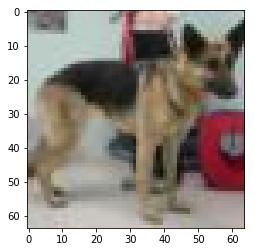

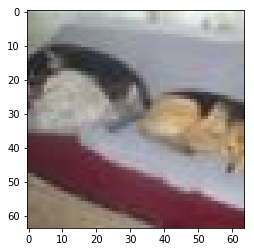

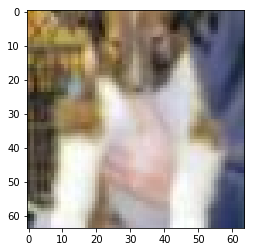

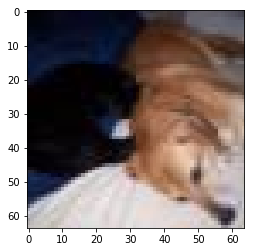

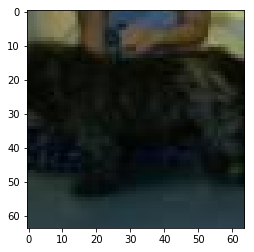

In [17]:
#Print clearly misclassified images
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
print(misclass_max)
missed = []
for i in range(len(images_misclass)):
  img = np.zeros((64,64,3))
  img[:,:,0] = images_misclass[i][0]
  img[:,:,1] = images_misclass[i][1]
  img[:,:,2] = images_misclass[i][2]
  name = 'miscalss_num_'+str(i)+'.jpg'
  scipy.misc.toimage(img).save(name)
  plt.imshow(img)
  plt.show()

C:\Users\mikap\Desktop\WPy-3670\python-3.6.7.amd64\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if __name__ == '__main__':


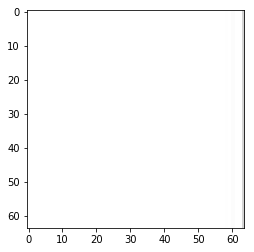

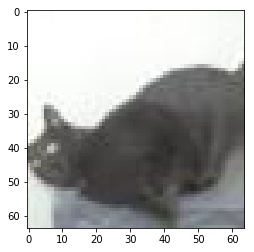

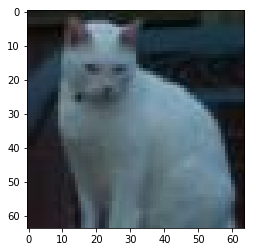

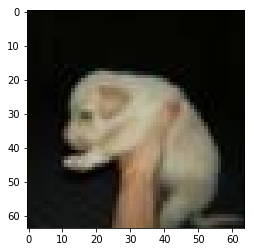

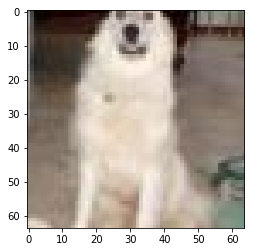

In [16]:
close = []
#Print close call images
for i in range(len(images_misclass)):
  img = np.zeros((64,64,3))
  img[:,:,0] = images_close[i][0]
  img[:,:,1] = images_close[i][1]
  img[:,:,2] = images_close[i][2]
  name = 'close_num_'+str(i)+'.jpg'
  scipy.misc.toimage(img).save(name)
  plt.imshow(img)
  plt.show()

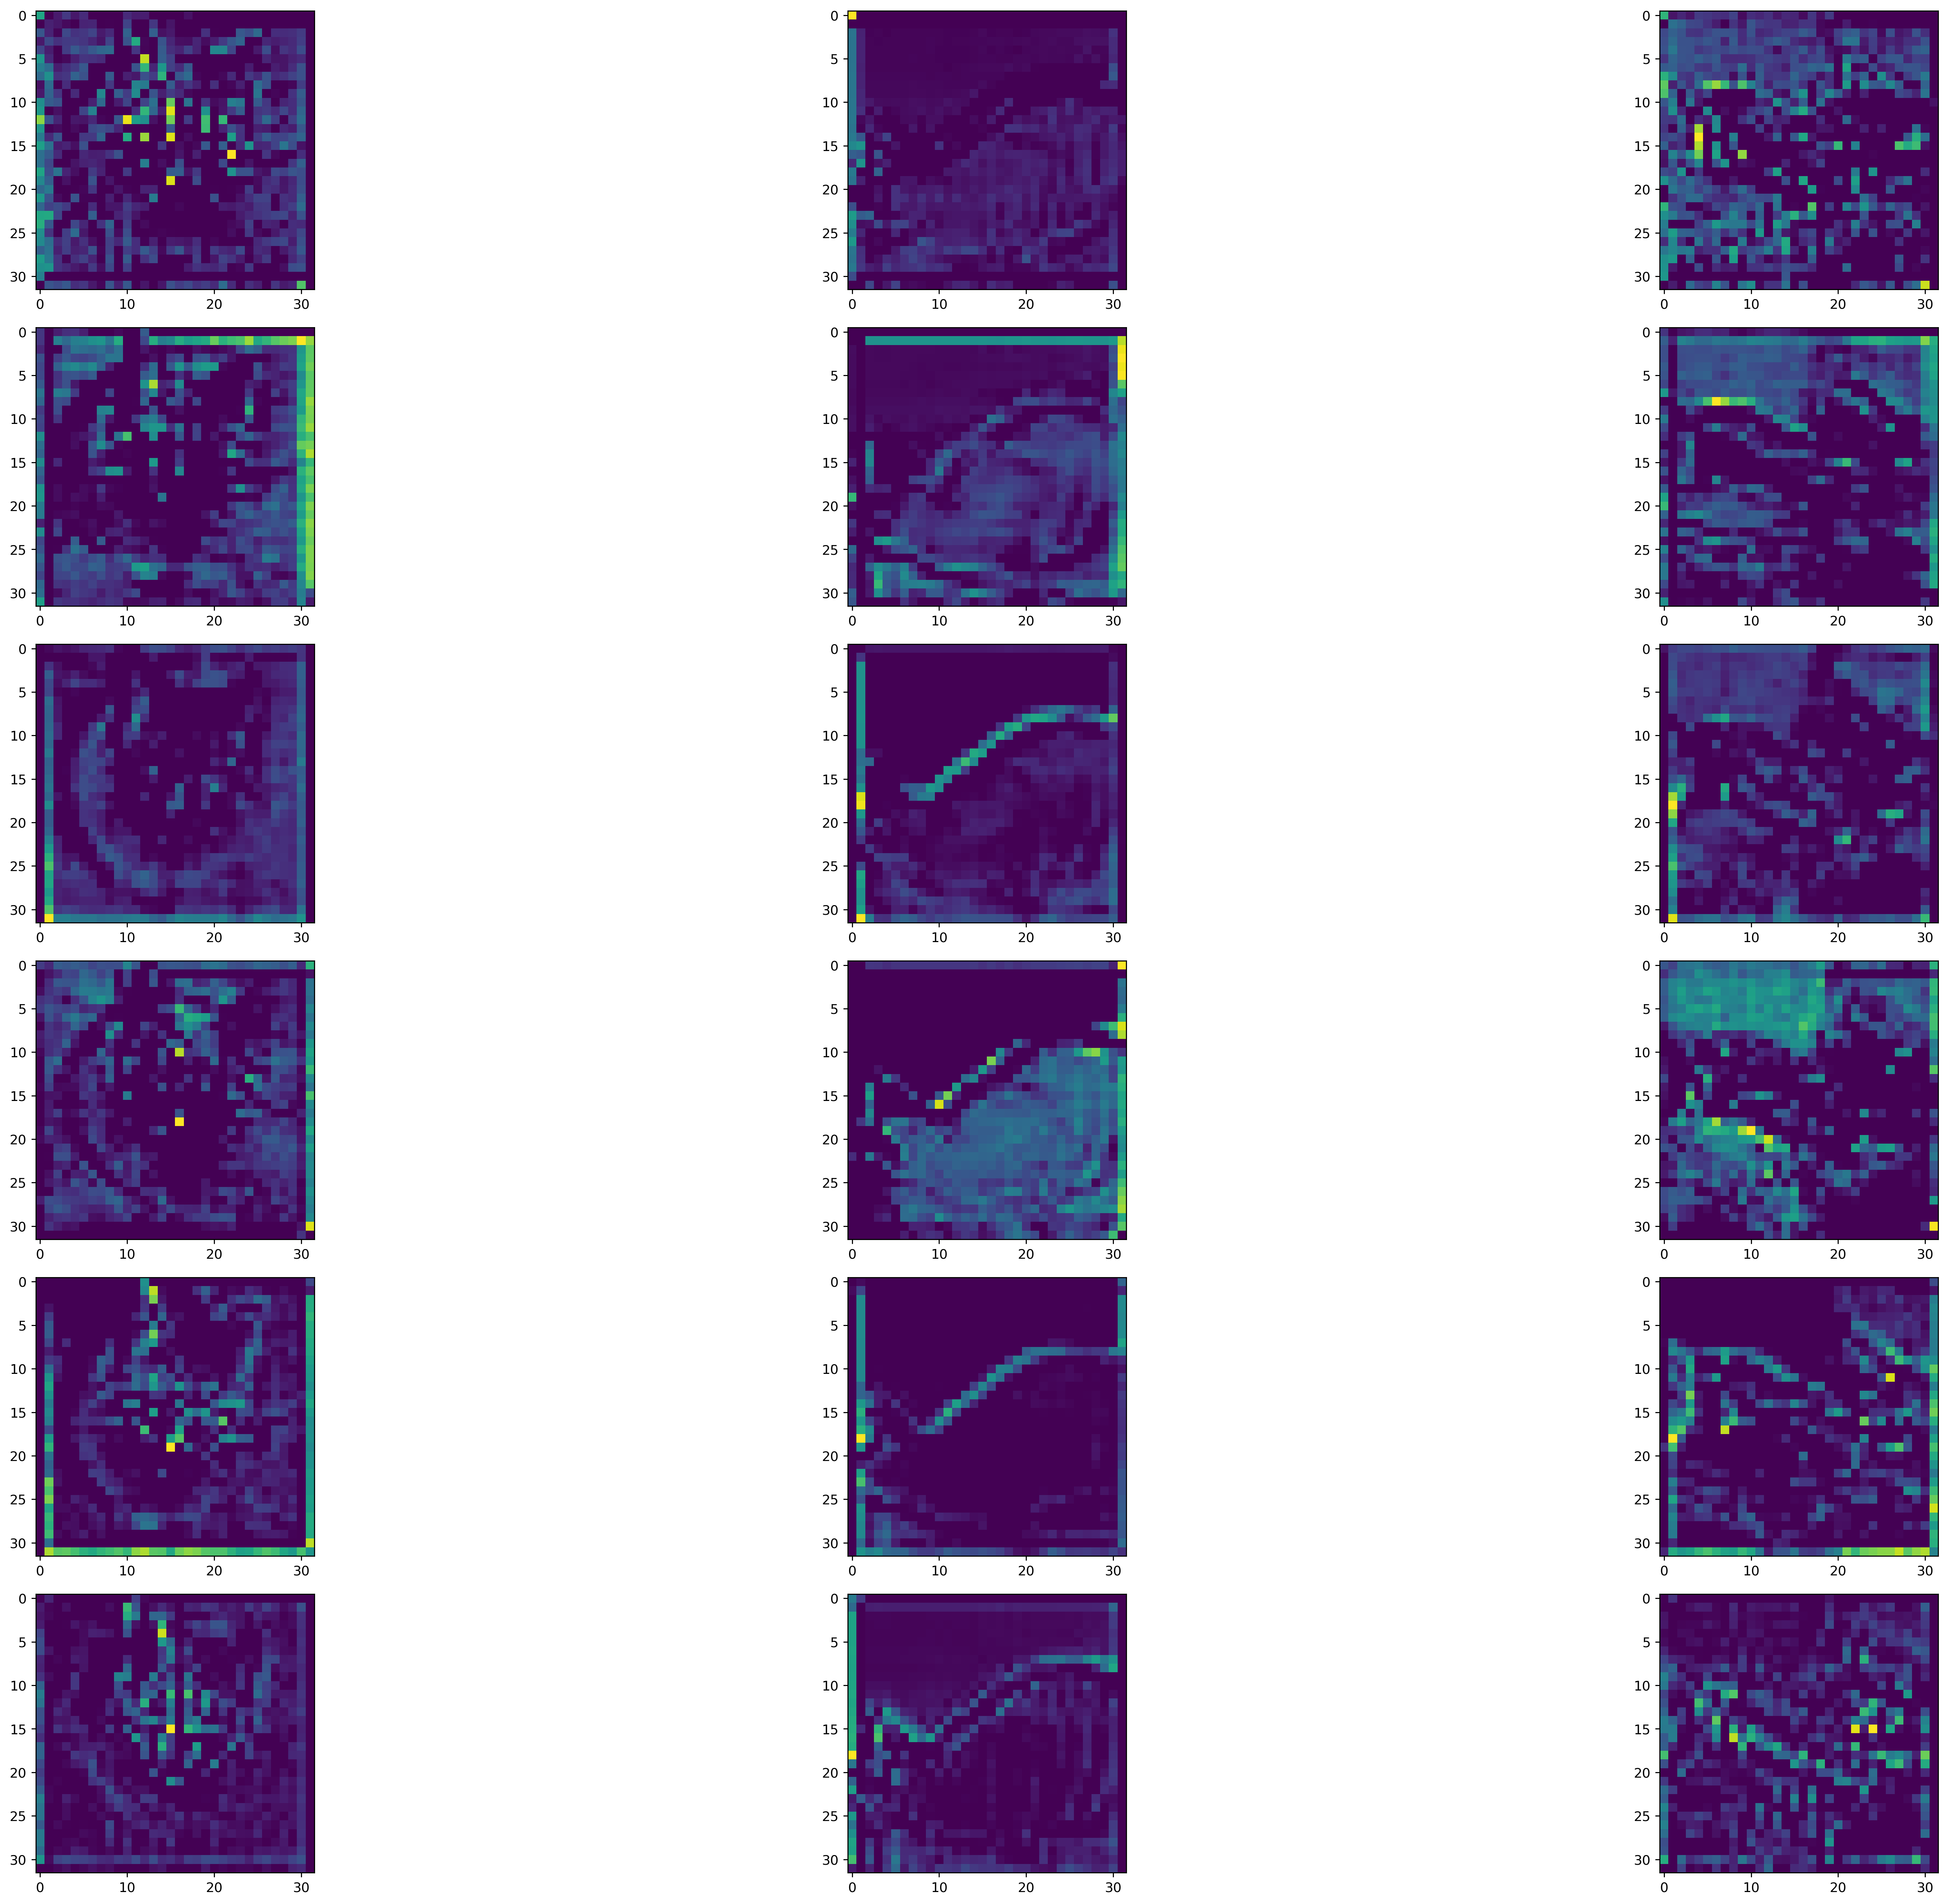

In [17]:
#This cell is for the subplots of the feature maps
import matplotlib.gridspec as gridspec
featurelist = model.features

channel=numpy.arange(10,128,20) # channel #




previous_good=im_fm_good_tens
im_fm_close=images_close[1].unsqueeze(0)
im_fm_close = im_fm_close.to(device)
previous_close=im_fm_close
im_fm_miss=images_misclass[2].unsqueeze(0)
im_fm_miss = im_fm_miss.to(device)
previous_miss=im_fm_miss
fig=plt.figure(figsize=(30,20), dpi=256)

for count, op in enumerate(range(len(featurelist))):
  out_good=featurelist[op](previous_good)
  out_close=featurelist[op](previous_close)
  out_miss=featurelist[op](previous_miss)
  if count==6:
    
    for g, h in enumerate(channel):
      showcase_good=out_good[0][h].cpu().detach().numpy()
      showcase_close=out_close[0][h].cpu().detach().numpy()
      showcase_miss=out_miss[0][h].cpu().detach().numpy()
      
      plt.subplot2grid((6,3),(g,0))
      plt.imshow(showcase_good)
      plt.subplot2grid((6,3),(g,1))
      plt.imshow(showcase_close)
      plt.subplot2grid((6,3),(g,2))
      plt.imshow(showcase_miss)
    plt.tight_layout()
    plt.show()
    fig.savefig('full_figure.png')
    
      
      

  previous_good=out_good
  previous_close=out_close
  previous_miss=out_miss